<a href="https://colab.research.google.com/github/YossefMohamed/Detecting-COVID-19-Through-Sound/blob/main/FinalDLmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import cv2
import os

---
# 1-Prepare Data
---



**DOWNLOAD DATA**

In [2]:
!git clone https://github.com/iiscleap/Coswara-Data.git

Cloning into 'Coswara-Data'...
remote: Enumerating objects: 798, done.
remote: Total 798 (delta 0), reused 0 (delta 0), pack-reused 798
Receiving objects: 100% (798/798), 15.97 GiB | 26.41 MiB/s, done.
Resolving deltas: 100% (310/310), done.
Checking out files: 100% (202/202), done.


In [2]:
rt_dir = '/content/Coswara-Data'
import glob
for each in os.listdir(rt_dir):
    if os.path.isdir(os.path.join(rt_dir,each)) and each != '.git':
        print(each)
        !cat {os.path.join(rt_dir, each,'')}*.tar.gz.* > {os.path.join(rt_dir, each,'')}combined_file.tar.gz
        !tar -xzf {os.path.join(rt_dir, each,'')}combined_file.tar.gz -C {rt_dir}
subset = glob.glob('/content/Coswara-Data/*/*.tar.gz.*') + glob.glob('/content/Coswara-Data/*/combined_data.tar.gz')
[os.remove(x) for x in subset];

20210206
cat: '/content/Coswara-Data/20210206/*.tar.gz.*': No such file or directory

gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
20200505
cat: '/content/Coswara-Data/20200505/*.tar.gz.*': No such file or directory

gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
20200415
cat: '/content/Coswara-Data/20200415/*.tar.gz.*': No such file or directory

gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
20210603
cat: '/content/Coswara-Data/20210603/*.tar.gz.*': No such file or directory

gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
20200911
cat: '/content/Coswara-Data/20200911/*.tar.gz.*': No such file or directory

gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
20200901
cat: '/content/Coswar

In [4]:
import glob
names   = ['ID','Fever/MP','ORC','STATUS','DIR','DataSet']
join_by = pd.read_csv('/content/Coswara-Data/combined_data.csv')

df_list = []
for path in tqdm(glob.glob('/content/Coswara-Data/*/*/cough-shallow.wav')):
  temp = pd.DataFrame(columns=['id','DIR'])
  temp['id'] = [path.split('/')[-2]]
  temp['DIR'] = [path]
  temp = pd.merge(left=temp,right=join_by,on='id',how='inner')

  temp['fomp']= (temp['fever']| temp['mp']).apply(int)
  temp['oths']= (temp['cld']|temp['asthma']|temp['cold']|temp['st']|temp['pneumonia']).apply(int)
  temp        = temp[['id','covid_status','DIR','fomp','oths']]
  df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR':'DIR','fomp':'Fever/MP','oths':'ORC'}))
CosData=pd.concat(df_list)
CosData['DataSet'] = 'coswara'


100%|██████████| 2745/2745 [00:30<00:00, 91.43it/s]


In [5]:
!wget https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
!mv public_dataset.zip?download=1 public_dataset.zip
!unzip -q public_dataset.zip
!mkdir 'custom_dataset'

--2022-03-02 21:44:29--  https://zenodo.org/record/4048312/files/public_dataset.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 951442487 (907M) [application/octet-stream]
Saving to: ‘public_dataset.zip?download=1’

public_dataset.zip? 100%[===================>] 907.37M  40.2MB/s    in 13s     

2022-03-02 21:44:43 (71.7 MB/s) - ‘public_dataset.zip?download=1’ saved [951442487/951442487]

replace public_dataset/00039425-7f3a-42aa-ac13-834aaa2b6b92.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
mkdir: cannot create directory ‘custom_dataset’: File exists


In [6]:
from google.colab import data_table
data_table.DataTable(CosData)

,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,CU6Sqlt8NfMboou9neSzsyNLyKD2,healthy,/content/Coswara-Data/20210206/CU6Sqlt8NfMboou...,0,1,coswara
0,Bb9OMQWb3GNbJDH4gANBkWJ4Ihs1,healthy,/content/Coswara-Data/20210206/Bb9OMQWb3GNbJDH...,0,0,coswara
0,smnOOz3onPU2GxyyQuwVJuiU0No1,healthy,/content/Coswara-Data/20210206/smnOOz3onPU2Gxy...,0,0,coswara
0,yL9QW3T2VueXfL3yvsmXsM2hL4v1,positive_mild,/content/Coswara-Data/20210206/yL9QW3T2VueXfL3...,0,1,coswara
0,KYFep4QYHeTdetDl8dhMl0je3ux1,healthy,/content/Coswara-Data/20210206/KYFep4QYHeTdetD...,0,0,coswara
...,...,...,...,...,...,...
0,Xn3y4lqypTNVBsB1yYYkDDypizk2,recovered_full,/content/Coswara-Data/20210426/Xn3y4lqypTNVBsB...,0,0,coswara
0,w5duFqV8D8V8c0hZLdmvSkmgcmz1,no_resp_illness_exposed,/content/Coswara-Data/20210426/w5duFqV8D8V8c0h...,0,0,coswara
0,hB8ntHij4nOm6YoGj86MtZJVTyr2,healthy,/content/Coswara-Data/20210426/hB8ntHij4nOm6Yo...,0,0,coswara
0,R2GSpbi6GQWiCzz17TR8yj4UB4a2,no_resp_illness_exposed,/content/Coswara-Data/20210426/R2GSpbi6GQWiCzz...,0,0,coswara


In [7]:
CosData['STATUS'].unique()

array(['healthy', 'positive_mild', 'no_resp_illness_exposed',
       'recovered_full', 'resp_illness_not_identified', 'positive_asymp',
       'positive_moderate', 'under_validation'], dtype=object)

In [8]:
positive_mild = CosData.loc[CosData['STATUS']=='positive_mild']
positive_moderate	 = CosData.loc[CosData['STATUS']=='positive_moderate']
positive_asymp = CosData.loc[CosData['STATUS']=='positive_asymp']

coswara_positive = pd.concat([positive_mild,positive_moderate,positive_asymp])

healthy = CosData.loc[CosData['STATUS']=='healthy']
resp_illness_not_identified = CosData.loc[CosData['STATUS']=='resp_illness_not_identified']
no_resp_illness_exposed = CosData.loc[CosData['STATUS']=='no_resp_illness_exposed']
recovered_full = CosData.loc[CosData['STATUS']=='recovered_full']

negative =  pd.concat([healthy,resp_illness_not_identified,no_resp_illness_exposed,recovered_full])

print(len(coswara_positive))
print(len(negative))
f_negative = negative.loc[negative['STATUS']!='COVID-19'][0:1000]
print(len(f_negative))



681
1983
1000


In [9]:
del(negative)

In [10]:
data_table.DataTable(f_negative )

,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,CU6Sqlt8NfMboou9neSzsyNLyKD2,healthy,/content/Coswara-Data/20210206/CU6Sqlt8NfMboou...,0,1,coswara
0,Bb9OMQWb3GNbJDH4gANBkWJ4Ihs1,healthy,/content/Coswara-Data/20210206/Bb9OMQWb3GNbJDH...,0,0,coswara
0,smnOOz3onPU2GxyyQuwVJuiU0No1,healthy,/content/Coswara-Data/20210206/smnOOz3onPU2Gxy...,0,0,coswara
0,KYFep4QYHeTdetDl8dhMl0je3ux1,healthy,/content/Coswara-Data/20210206/KYFep4QYHeTdetD...,0,0,coswara
0,D5aq6FUMeCQal79ePD7UZniIyF12,healthy,/content/Coswara-Data/20210206/D5aq6FUMeCQal79...,0,0,coswara
...,...,...,...,...,...,...
0,c96Fr87Qw8cbz2JKR4yE6DiuSrq1,healthy,/content/Coswara-Data/20210816/c96Fr87Qw8cbz2J...,0,0,coswara
0,XAQ5xkTIEHXSPX6q02PJ6WvPNuD3,healthy,/content/Coswara-Data/20210816/XAQ5xkTIEHXSPX6...,0,0,coswara
0,hbLP3s7RLsTgaMSRNWkIuuggpyL2,healthy,/content/Coswara-Data/20210816/hbLP3s7RLsTgaMS...,0,0,coswara
0,WcRpZenx0WWQmzOUPTHEEGlyJAg1,healthy,/content/Coswara-Data/20210816/WcRpZenx0WWQmzO...,0,0,coswara


## COUGHVID

In [11]:
coughvid  = '/content/public_dataset/'
custpath  = '/content/custom_dataset/' #Where mel spec images will be stored

VidData   = pd.read_csv(os.path.join(coughvid,'metadata_compiled.csv'),header=0)
VidData   = VidData.loc[VidData['cough_detected'] >= 0.9][['uuid','fever_muscle_pain','respiratory_condition','status']]
VidData.dropna(inplace=True)

coughvid_positive = VidData.loc[VidData['status']=='COVID-19']
coughvid_negative = VidData.loc[VidData['status']!='COVID-19'] [0:1200]


In [12]:
len(coughvid_negative)

1200

In [13]:
VidData['status'].unique()

array(['healthy', 'symptomatic', 'COVID-19'], dtype=object)

In [ ]:

TotData   = pd.concat([coughvid_positive,coughvid_negative],ignore_index= True)
TotData['DIR'] = coughvid + TotData['uuid'] + '.webm'
TotData['DataSet'] = 'coughvid'
TotData['fever_muscle_pain']    = TotData['fever_muscle_pain'].apply(int)
TotData['respiratory_condition']= TotData['respiratory_condition'].apply(int)
TotData   = pd.concat([CosData,TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})])
TotData   = TotData.sample(frac=1).reset_index(drop=True)

In [14]:

coughvid_positive['DIR'] = coughvid + coughvid_positive['uuid'] + '.webm'
coughvid_positive['DataSet'] = 'coughvid'
coughvid_positive['fever_muscle_pain']    = coughvid_positive['fever_muscle_pain'].apply(int)
coughvid_positive['respiratory_condition']= coughvid_positive['respiratory_condition'].apply(int)
coughvid_positive =coughvid_positive.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})
coughvid_positive  = coughvid_positive.sample(frac=1).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [15]:

coughvid_negative['DIR'] = coughvid + coughvid_negative['uuid'] + '.webm'
coughvid_negative['DataSet'] = 'coughvid'
coughvid_negative['fever_muscle_pain']    = coughvid_negative['fever_muscle_pain'].apply(int)
coughvid_negative['respiratory_condition']= coughvid_negative['respiratory_condition'].apply(int)
coughvid_negative =coughvid_negative.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})
coughvid_negative = coughvid_negative.sample(frac=1).reset_index(drop=True)

In [ ]:
data_table.DataTable(TotData )

In [16]:
data_table.DataTable(coughvid_positive )

,ID,Fever/MP,ORC,STATUS,DIR,DataSet
0,edd0f863-340f-4e5b-b4ce-a0ef86db8d9a,0,0,COVID-19,/content/public_dataset/edd0f863-340f-4e5b-b4c...,coughvid
1,4c58cf95-9b2e-4091-adaa-0ac06a355c48,0,0,COVID-19,/content/public_dataset/4c58cf95-9b2e-4091-ada...,coughvid
2,9bbc6186-f18d-4a96-b92b-37d25b390bdf,1,1,COVID-19,/content/public_dataset/9bbc6186-f18d-4a96-b92...,coughvid
3,f8053fc3-bc4e-403b-b9d4-14133cfe83a6,0,1,COVID-19,/content/public_dataset/f8053fc3-bc4e-403b-b9d...,coughvid
4,3be5af36-9e52-465a-81a6-da1c60d350f5,0,0,COVID-19,/content/public_dataset/3be5af36-9e52-465a-81a...,coughvid
...,...,...,...,...,...,...
436,906c93d3-6615-478b-a7a1-803a5a15d360,0,1,COVID-19,/content/public_dataset/906c93d3-6615-478b-a7a...,coughvid
437,76779311-1f9c-40b5-845d-bde19b0d9c0e,1,0,COVID-19,/content/public_dataset/76779311-1f9c-40b5-845...,coughvid
438,4d230bec-1056-49ca-b274-c0825b924824,0,0,COVID-19,/content/public_dataset/4d230bec-1056-49ca-b27...,coughvid
439,63f4e572-e693-4265-8b77-07f552fc63e9,0,0,COVID-19,/content/public_dataset/63f4e572-e693-4265-8b7...,coughvid


# 2-Data Augmentaion

In [17]:
!pip install audiomentations

In [18]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import soundfile as sf
import librosa

In [20]:
!mkdir augmented_data
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

In [21]:
aug_coswara_positive = pd.DataFrame()
for audio_file in  tqdm(coswara_positive["DIR"]):
  try:
    samples, sr = librosa.load(audio_file)
    augmented_sample = augment(samples=samples, sample_rate=sr)
    sf.write("/content/augmented_data/" + audio_file.split("/")[-2] + ".wav", augmented_sample, sr) #write with wav extantion

    aug_coswara_positive = aug_coswara_positive.append(coswara_positive.loc[coswara_positive['ID'] == audio_file.split("/")[-2]])
    aug_coswara_positive["DIR"].replace({ audio_file : "/content/augmented_data/" + audio_file.split("/")[-2] + ".wav"}, inplace=True)
    aug_coswara_positive["ID"].replace({ audio_file.split("/")[-2] :  audio_file.split("/")[-2] + "AUG"}, inplace=True)

  except:
    print("\n File Not Found :))")

 59%|█████▉    | 405/681 [02:24<01:37,  2.84it/s]


 File Not Found :))


 81%|████████  | 552/681 [03:19<01:05,  1.98it/s]


 File Not Found :))


 96%|█████████▌| 654/681 [03:55<00:11,  2.44it/s]


 File Not Found :))


100%|██████████| 681/681 [04:07<00:00,  2.75it/s]


In [22]:
len(aug_coswara_positive)

678

In [23]:
aug_coughvid_positive = pd.DataFrame()

for audio_file in  tqdm(coughvid_positive["DIR"]):
  try:
    samples, sr = librosa.load(audio_file)
    augmented_sample = augment(samples=samples, sample_rate=sr)
    sf.write("/content/augmented_data/" + audio_file.split("/")[-1][0:-5] + ".wav", augmented_sample, sr) #write with wav extantion

    aug_coughvid_positive = aug_coughvid_positive.append(coughvid_positive.loc[coughvid_positive['ID'] == audio_file.split("/")[-1][0:-5]])
    aug_coughvid_positive["DIR"].replace({"/content/augmented_data/"+ audio_file.split("/")[-1][0:-5] + ".webm": "/content/augmented_data/" + audio_file.split("/")[-1][0:-5] + ".wav"}, inplace=True)
    aug_coughvid_positive["ID"].replace({ audio_file.split("/")[-1][0:-5] :  audio_file.split("/")[-1][0:-5] + "AUG"}, inplace=True)

  except:
    print("\n File cannot open)")

  0%|          | 0/441 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/441 [00:01<10:45,  1.47s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/441 [00:01<06:32,  1.12it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 3/441 [00:02<05:17,  1.38it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 4/441 [00:03<05:47,  1.26it/s]/usr/local/li


 File cannot open)


 28%|██▊       | 123/441 [01:52<04:31,  1.17it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 124/441 [01:53<05:05,  1.04it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 125/441 [01:54<04:44,  1.11it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▊       | 126/441 [01:55<04:56,  1.06it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 127/441 [01:56<04:47,  1.09


 File cannot open)


 48%|████▊     | 210/441 [03:06<02:23,  1.61it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 211/441 [03:08<02:55,  1.31it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 212/441 [03:08<02:53,  1.32it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 48%|████▊     | 213/441 [03:09<02:59,  1.27it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 49%|████▊     | 214/441 [03:10<02:40,  1.42


 File cannot open)


 51%|█████     | 226/441 [03:18<02:36,  1.37it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 51%|█████▏    | 227/441 [03:19<02:58,  1.20it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 52%|█████▏    | 228/441 [03:20<02:58,  1.19it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 52%|█████▏    | 229/441 [03:21<02:44,  1.29it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 52%|█████▏    | 230/441 [03:22<02:39,  1.33


 File cannot open)


 60%|█████▉    | 264/441 [03:48<02:26,  1.21it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|██████    | 265/441 [03:49<02:37,  1.12it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 60%|██████    | 266/441 [03:50<02:29,  1.17it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 61%|██████    | 267/441 [03:51<02:14,  1.29it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 61%|██████    | 268/441 [03:51<02:11,  1.31


 File cannot open)


 71%|███████   | 312/441 [04:31<01:32,  1.40it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████   | 313/441 [04:32<01:48,  1.18it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████   | 314/441 [04:33<01:48,  1.17it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 71%|███████▏  | 315/441 [04:34<01:55,  1.09it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 72%|███████▏  | 316/441 [04:34<01:41,  1.24


 File cannot open)


 80%|███████▉  | 352/441 [05:03<00:52,  1.69it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 80%|████████  | 353/441 [05:04<01:03,  1.38it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 80%|████████  | 354/441 [05:05<01:03,  1.37it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 80%|████████  | 355/441 [05:05<01:04,  1.32it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 81%|████████  | 356/441 [05:06<01:04,  1.32


 File cannot open)


 95%|█████████▌| 421/441 [06:07<00:17,  1.14it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▌| 422/441 [06:08<00:18,  1.04it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▌| 423/441 [06:09<00:15,  1.19it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▌| 424/441 [06:09<00:13,  1.23it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 96%|█████████▋| 425/441 [06:11<00:15,  1.06

In [31]:
print(len(coswara_positive))
print(len(coughvid_positive))
print(len(aug_coughvid_positive ))
print(len(aug_coswara_positive ))
print(len(coughvid_negative ))
print(len(f_negative) )
print("total data:  "+ str(1000+1200+678+434+441+681))
print("aug data:  "+ str(678+434))

681
441
434
678
1200
1000
total data:  4434
aug data:  1112


In [ ]:
1000+681+678+4

#spilt to train - test - validation


In [32]:

coughvid_positive_train = coughvid_positive[:int(0.8*len(coughvid_positive))]  
coughvid_positive_test = coughvid_positive[ int(0.8*len(coughvid_positive)): int(0.9*len(coughvid_positive))]  
coughvid_positive_val = coughvid_positive[ int(0.9*len(coughvid_positive)) :]


coughvid_negative_train = coughvid_negative[:int(0.8*len(coughvid_negative))]  
coughvid_negative_test = coughvid_negative[ int(0.8*len(coughvid_negative)): int(0.9*len(coughvid_negative))]
coughvid_negative_val = coughvid_negative[ int(0.9*len(coughvid_negative)) :]

aug_covid_samples_train = aug_coughvid_positive[:int(0.8*len(aug_coughvid_positive))]  
aug_covid_samples_test = aug_coughvid_positive[ int(0.8*len(aug_coughvid_positive)): int(0.9*len(aug_coughvid_positive))]
aug_covid_samples_val = aug_coughvid_positive[ int(0.9*len(aug_coughvid_positive)) :]



aug_positive_samples_train = aug_coswara_positive[:int(0.8*len(aug_coswara_positive))]  
aug_positive_samples_test = aug_coswara_positive[ int(0.8*len(aug_coswara_positive)): int(0.9*len(aug_coswara_positive))]
aug_positive_samples_val = aug_coswara_positive[ int(0.9*len(aug_coswara_positive)) :]



coswara_positive_samples_train = coswara_positive[:int(0.8*len(coswara_positive))]    
coswara_positive_samples_test = coswara_positive[ int(0.8*len(coswara_positive)): int(0.9*len(coswara_positive))]
coswara_positive_samples_val = coswara_positive[ int(0.9*len(coswara_positive)) :]


negative_samples_train = f_negative[:int(0.8*len(f_negative))]    
negative_samples_test = f_negative[ int(0.8*len(f_negative)): int(0.9*len(f_negative))]
negattive_samples_val = f_negative[ int(0.9*len(f_negative)) :]


In [33]:
#train Data
train = [coughvid_positive_train,coughvid_negative_train,aug_positive_samples_train,aug_positive_samples_train,coswara_positive_samples_train,negative_samples_train]
Data_train = pd.concat(train)


# validation Data
val =[coughvid_positive_val,coughvid_negative_val,aug_positive_samples_val,aug_positive_samples_val,coswara_positive_samples_val,negattive_samples_val]
Data_val = pd.concat(val)

# test Data
test = [coughvid_positive_test,coughvid_negative_test,aug_positive_samples_test,aug_positive_samples_test,coswara_positive_samples_test,negative_samples_test]
Data_test = pd.concat(test)
print(len(Data_train) , len(Data_val) , len(Data_test))

3740 470 468






## Feature Extraction

In [34]:
def feature_extractor(row):

  name     = row[-6]
  try:
    audio,sr = librosa.load(row[-2])
    #For MFCCS 
    mfccs    = librosa.feature.mfcc(y=audio,sr=22050, n_mfcc=13)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    
    #Mel Spectogram
    pylab.axis('off') # no axis
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
    s_db     = librosa.power_to_db(melspec, ref=np.max)
    librosa.display.specshow(s_db)

    savepath = os.path.join(custpath,name+'.png')
    pylab.savefig(savepath, bbox_inches=None, pad_inches=0)
    pylab.close()
  except:
    print('File cannot open')
    return None,None
   # return mfccsscaled

  return mfccsscaled,savepath

#train
features_train = []
diagnoses_train= []
imgpaths_train = []
#validation
features_val = []
diagnoses_val= []
imgpaths_val = []
#test
features_test = []
diagnoses_test= []
imgpaths_test = []

In [35]:
# train
for row in tqdm(Data_train.values):
  mfccs,savepath  = feature_extractor(row)
  features_train.append(mfccs)
  imgpaths_train.append(savepath)
  diagnoses_train.append([row[-5],row[-4]])

  0%|          | 0/3740 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/3740 [00:00<44:31,  1.40it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/3740 [00:01<42:48,  1.46it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 3/3740 [00:02<42:54,  1.45it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 4/3740 [00:03<50:02,  1.24it/s]/usr/loc

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 123/3740 [01:54<50:17,  1.20it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 124/3740 [01:55<53:49,  1.12it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 125/3740 [01:56<56:31,  1.07it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  3%|▎         | 126/3740 [01:57<58:20,  1.03it/s]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 210/3740 [03:18<44:36,  1.32it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 211/3740 [03:19<49:53,  1.18it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 212/3740 [03:20<53:36,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 213/3740 [03:21<56:23,  1.04it/s]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 226/3740 [03:32<51:00,  1.15it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 227/3740 [03:34<57:50,  1.01it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 228/3740 [03:35<59:41,  1.02s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 229/3740 [03:36<56:50,  1.03it/s]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 264/3740 [04:10<53:07,  1.09it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 265/3740 [04:11<55:09,  1.05it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 266/3740 [04:12<58:11,  1.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  7%|▋         | 267/3740 [04:13<56:43,  1.02it/s]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 312/3740 [05:01<52:59,  1.08it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 313/3740 [05:02<56:50,  1.00it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 314/3740 [05:03<59:27,  1.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 315/3740 [05:04<1:01:12,  1.07s/it]/usr/local/lib/python3.7/dist-packages

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 352/3740 [05:48<50:11,  1.13it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 353/3740 [05:49<54:17,  1.04it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 354/3740 [05:50<57:48,  1.02s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  9%|▉         | 355/3740 [05:51<1:00:37,  1.07s/it]/usr/local/lib/python3.7/dist-packages

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 362/3740 [05:58<50:46,  1.11it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 363/3740 [05:59<55:17,  1.02it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 364/3740 [06:00<56:40,  1.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 365/3740 [06:01<59:50,  1.06s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 369/3740 [06:05<51:33,  1.09it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 370/3740 [06:06<51:39,  1.09it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 371/3740 [06:06<41:49,  1.34it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 372/3740 [06:07<49:10,  1.14it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|▉         | 373/3740 [06:08<54:06,  1.04it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 374/3740 [06:09<43:37,  1.29it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 375/3740 [06:10<50:23,  1.11it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 376/3740 [06:11<55:13,  1.02it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 377/3740 [06:12<53:55,  1.04it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 378/3740 [06:13<50:10,  1.12it/s]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 413/3740 [06:49<50:36,  1.10it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 414/3740 [06:51<55:31,  1.00s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 415/3740 [06:52<59:12,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 416/3740 [06:53<1:01:31,  1.11s/it]/usr/local/lib/python3.7/dist-packages

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 418/3740 [06:55<54:22,  1.02it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 419/3740 [06:55<51:20,  1.08it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 420/3740 [06:57<55:40,  1.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█▏        | 421/3740 [06:58<58:26,  1.06s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 439/3740 [07:16<47:21,  1.16it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 440/3740 [07:17<52:53,  1.04it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 441/3740 [07:18<57:00,  1.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 442/3740 [07:19<59:54,  1.09s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 444/3740 [07:21<53:14,  1.03it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 445/3740 [07:22<57:23,  1.05s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 446/3740 [07:23<1:00:03,  1.09s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 447/3740 [07:24<48:16,  1.14it/s]  

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 448/3740 [07:25<49:23,  1.11it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 449/3740 [07:26<54:50,  1.00it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 450/3740 [07:27<53:51,  1.02it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 12%|█▏        | 451/3740 [07:28<57:37,  1.05s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▎        | 510/3740 [08:36<55:13,  1.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▎        | 511/3740 [08:37<53:22,  1.01it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▎        | 512/3740 [08:38<57:58,  1.08s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 14%|█▎        | 513/3740 [08:39<57:02,  1.06s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 547/3740 [09:19<55:27,  1.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 548/3740 [09:21<58:48,  1.11s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 549/3740 [09:22<1:01:22,  1.15s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 550/3740 [09:23<1:02:17,  1.17s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 554/3740 [09:27<51:28,  1.03it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 555/3740 [09:28<53:13,  1.00s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 556/3740 [09:29<54:15,  1.02s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▍        | 557/3740 [09:30<58:09,  1.10s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 579/3740 [09:56<56:19,  1.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 580/3740 [09:57<58:07,  1.10s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 581/3740 [09:58<1:01:15,  1.16s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 582/3740 [10:00<1:03:15,  1.20s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 590/3740 [10:08<49:03,  1.07it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 591/3740 [10:09<54:10,  1.03s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 592/3740 [10:10<51:03,  1.03it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 593/3740 [10:10<42:38,  1.23it/s]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 594/3740 [10:11<45:56,  1.14it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 595/3740 [10:13<52:20,  1.00it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 596/3740 [10:14<57:22,  1.09s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 597/3740 [10:15<1:00:27,  1.15s/it]/usr/local/lib/python3.7/dist-packages

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 604/3740 [10:23<56:23,  1.08s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 605/3740 [10:25<59:55,  1.15s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 606/3740 [10:26<1:00:34,  1.16s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 607/3740 [10:27<58:43,  1.12s/it]  /usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▉        | 728/3740 [12:58<56:16,  1.12s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▉        | 729/3740 [12:59<1:00:10,  1.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 730/3740 [13:01<1:02:42,  1.25s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 731/3740 [13:02<1:04:55,  1.29s/it]/usr/local/lib/python3.7/dist-pack

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 739/3740 [13:12<54:43,  1.09s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 740/3740 [13:13<54:56,  1.10s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 741/3740 [13:14<59:20,  1.19s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 742/3740 [13:16<59:07,  1.18s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 764/3740 [13:43<56:07,  1.13s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 765/3740 [13:45<1:00:16,  1.22s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|██        | 766/3740 [13:46<59:16,  1.20s/it]  /usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 767/3740 [13:47<1:02:22,  1.26s/it]/usr/local/lib/python3.7/dist-pack

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 822/3740 [14:58<57:59,  1.19s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 823/3740 [14:59<1:01:20,  1.26s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 824/3740 [15:01<1:00:29,  1.24s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 825/3740 [15:02<58:07,  1.20s/it]  /usr/local/lib/python3.7/dist-pack

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 842/3740 [15:24<58:58,  1.22s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 843/3740 [15:25<1:01:44,  1.28s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 844/3740 [15:26<1:00:08,  1.25s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 845/3740 [15:28<1:02:53,  1.30s/it]/usr/local/lib/python3.7/dist-pack

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 873/3740 [16:05<57:06,  1.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 874/3740 [16:06<55:18,  1.16s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 875/3740 [16:07<54:24,  1.14s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 876/3740 [16:08<58:48,  1.23s/it]/usr/local/lib/python3.7/dist-packages/l

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 920/3740 [17:10<56:38,  1.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 921/3740 [17:11<1:00:25,  1.29s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 922/3740 [17:13<1:03:11,  1.35s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 923/3740 [17:14<1:02:11,  1.32s/it]/usr/local/lib/python3.7/dist-pack

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 932/3740 [17:26<52:50,  1.13s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 933/3740 [17:27<57:49,  1.24s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▍       | 934/3740 [17:29<1:01:22,  1.31s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 935/3740 [17:30<1:01:05,  1.31s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 966/3740 [18:13<56:18,  1.22s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 967/3740 [18:14<55:27,  1.20s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 968/3740 [18:16<59:44,  1.29s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 26%|██▌       | 969/3740 [18:17<1:02:41,  1.36s/it]/usr/local/lib/python3.7/dist-packages

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 998/3740 [18:57<57:19,  1.25s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 999/3740 [18:59<1:00:54,  1.33s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1000/3740 [19:00<1:01:20,  1.34s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1001/3740 [19:02<1:00:58,  1.34s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1006/3740 [19:08<56:46,  1.25s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1007/3740 [19:09<1:00:32,  1.33s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1008/3740 [19:11<1:03:25,  1.39s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 27%|██▋       | 1009/3740 [19:12<1:00:39,  1.33s/it]/usr/local/lib/python3.7/dist-

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1081/3740 [20:52<56:14,  1.27s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1082/3740 [20:54<59:57,  1.35s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1083/3740 [20:55<1:02:52,  1.42s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 1084/3740 [20:57<1:04:44,  1.46s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1109/3740 [21:32<57:04,  1.30s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1110/3740 [21:34<1:00:38,  1.38s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1111/3740 [21:35<1:03:10,  1.44s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 30%|██▉       | 1112/3740 [21:37<1:04:53,  1.48s/it]/usr/local/lib/python3.7/dist-

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1181/3740 [23:23<55:30,  1.30s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1182/3740 [23:24<59:13,  1.39s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1183/3740 [23:26<1:02:16,  1.46s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 32%|███▏      | 1184/3740 [23:28<1:04:34,  1.52s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 1251/3740 [25:10<55:35,  1.34s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 1252/3740 [25:11<1:02:24,  1.50s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▎      | 1253/3740 [25:13<1:04:26,  1.55s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▎      | 1254/3740 [25:14<1:01:38,  1.49s/it]/usr/local/lib/python3.7/dist-

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 1280/3740 [25:54<57:00,  1.39s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 1281/3740 [25:56<57:13,  1.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 1282/3740 [25:57<55:45,  1.36s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 1283/3740 [25:59<56:57,  1.39s/it]/usr/local/lib/python3.7/dist-packag

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 1287/3740 [26:04<56:13,  1.38s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 1288/3740 [26:06<59:58,  1.47s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 1289/3740 [26:07<1:02:38,  1.53s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 1290/3740 [26:09<1:04:18,  1.57s/it]/usr/local/lib/python3.7/dist-pa

File cannot open


 81%|████████  | 3025/3740 [34:55<04:26,  2.68it/s]

File cannot open


 83%|████████▎ | 3112/3740 [35:32<04:58,  2.11it/s]

File cannot open


 84%|████████▍ | 3142/3740 [35:46<03:42,  2.69it/s]

File cannot open


 85%|████████▍ | 3162/3740 [35:55<04:48,  2.00it/s]

File cannot open


 85%|████████▌ | 3180/3740 [36:03<04:40,  2.00it/s]

File cannot open


 86%|████████▌ | 3198/3740 [36:10<04:01,  2.24it/s]

File cannot open


 86%|████████▌ | 3220/3740 [36:20<03:52,  2.24it/s]

File cannot open


 88%|████████▊ | 3275/3740 [36:44<03:07,  2.48it/s]

File cannot open


 94%|█████████▍| 3518/3740 [38:35<02:13,  1.66it/s]

File cannot open


 94%|█████████▍| 3532/3740 [38:40<01:22,  2.53it/s]

File cannot open


 95%|█████████▌| 3553/3740 [38:48<01:08,  2.73it/s]

File cannot open


 96%|█████████▌| 3573/3740 [38:56<01:16,  2.19it/s]

File cannot open


 96%|█████████▌| 3584/3740 [39:01<01:01,  2.52it/s]

File cannot open


 97%|█████████▋| 3619/3740 [39:16<00:54,  2.23it/s]

File cannot open


 97%|█████████▋| 3633/3740 [39:21<00:49,  2.18it/s]

File cannot open


 98%|█████████▊| 3673/3740 [39:40<00:28,  2.33it/s]

File cannot open


 99%|█████████▉| 3695/3740 [39:54<00:33,  1.34it/s]

File cannot open
File cannot open


100%|██████████| 3740/3740 [40:14<00:00,  1.55it/s]


In [36]:
#validation
for row in tqdm(Data_val.values):
  mfccs,savepath  = feature_extractor(row)
  features_val.append(mfccs)
  imgpaths_val.append(savepath)
  diagnoses_val.append([row[-5],row[-4]])

  0%|          | 0/470 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/470 [00:03<30:19,  3.88s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/470 [00:06<24:00,  3.08s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 3/470 [00:08<22:05,  2.84s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 4/470 [00:11<21:08,  2.72s/it]/usr/local/li

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  5%|▌         | 25/470 [01:01<16:48,  2.27s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 26/470 [01:04<17:24,  2.35s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 27/470 [01:06<17:19,  2.35s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  6%|▌         | 28/470 [01:08<17:11,  2.33s/it]/usr/local/lib/python3.7/dist-packages/librosa/c

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 47/470 [02:07<20:28,  2.90s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 48/470 [02:09<18:57,  2.69s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 10%|█         | 49/470 [02:12<18:26,  2.63s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 11%|█         | 50/470 [02:14<17:45,  2.54s/it]/usr/local/lib/python3.7/dist-packages/librosa/c

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 78/470 [03:19<14:27,  2.21s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 79/470 [03:22<14:57,  2.30s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 80/470 [03:24<15:16,  2.35s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 81/470 [03:27<15:28,  2.39s/it]/usr/local/lib/python3.7/dist-packages/librosa/c

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 102/470 [04:17<13:12,  2.15s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 103/470 [04:18<11:47,  1.93s/it]

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 104/470 [04:20<12:08,  1.99s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 22%|██▏       | 105/470 [04:22<12:42,  2.09s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 106/470 [04:25<13:24,  2.21s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 23%|██▎       | 107/470 [04:27<13:52,  2.29s/it]/usr/local/lib/python3.7/dist-packages/libro

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 132/470 [05:26<12:36,  2.24s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 133/470 [05:28<13:02,  2.32s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▊       | 134/470 [05:31<13:19,  2.38s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▊       | 135/470 [05:33<12:47,  2.29s/it]/usr/local/lib/python3.7/dist-packages/libro

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 73%|███████▎  | 343/470 [07:28<01:35,  1.34it/s]

File cannot open


 80%|███████▉  | 374/470 [07:44<00:56,  1.69it/s]

File cannot open


100%|█████████▉| 468/470 [08:24<00:00,  2.24it/s]

File cannot open


100%|██████████| 470/470 [08:25<00:00,  1.08s/it]


In [37]:
#test
for row in tqdm(Data_test.values):
  mfccs,savepath  = feature_extractor(row)
  features_test.append(mfccs)
  imgpaths_test.append(savepath)
  diagnoses_test.append([row[-5],row[-4]])

  0%|          | 0/468 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 1/468 [00:02<19:36,  2.52s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  0%|          | 2/468 [00:05<19:33,  2.52s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 3/468 [00:07<18:36,  2.40s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  1%|          | 4/468 [00:09<18:52,  2.44s/it]/usr/local/li

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 15%|█▌        | 72/468 [02:53<14:51,  2.25s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 73/468 [02:56<15:18,  2.33s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 74/468 [02:58<15:39,  2.38s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 16%|█▌        | 75/468 [03:01<15:28,  2.36s/it]/usr/local/lib/python3.7/dist-packages/librosa/c

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▉        | 90/468 [03:37<15:17,  2.43s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 19%|█▉        | 91/468 [03:40<15:40,  2.50s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 92/468 [03:42<15:32,  2.48s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 20%|█▉        | 93/468 [03:47<20:50,  3.33s/it]/usr/local/lib/python3.7/dist-packages/librosa/c

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 97/468 [03:56<14:12,  2.30s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 98/468 [03:58<13:53,  2.25s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██        | 99/468 [04:00<13:45,  2.24s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 21%|██▏       | 100/468 [04:02<13:06,  2.14s/it]/usr/local/lib/python3.7/dist-packages/librosa/

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 28%|██▊       | 133/468 [05:09<10:39,  1.91s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▊       | 134/468 [05:11<11:01,  1.98s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 135/468 [05:13<11:21,  2.05s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 29%|██▉       | 136/468 [05:15<11:07,  2.01s/it]/usr/local/lib/python3.7/dist-packages/libro

File cannot open


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 155/468 [05:54<10:13,  1.96s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 156/468 [05:56<10:27,  2.01s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▎      | 157/468 [05:59<10:43,  2.07s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 34%|███▍      | 158/468 [06:01<10:55,  2.11s/it]/usr/local/lib/python3.7/dist-packages/libro

File cannot open


 85%|████████▌ | 398/468 [07:24<00:33,  2.11it/s]

File cannot open


100%|██████████| 468/468 [07:55<00:00,  1.02s/it]


## Remove Nans





In [38]:
isnone = lambda x: x is not None
label_train  = lambda x: 1 if  x == 'COVID-19' or x == 'positive_mild'   or  x == 'positive_moderate'  or  x == 'positive_asymp'  else 0
cast_x_train = list(map(isnone,features_train))
data_y_train = list(map(label_train,Data_train['STATUS']))

data_x_train = [features_train[i] for i in range(len(features_train)) if cast_x_train[i] == True]
data_xx_train= [imgpaths_train[i] for i in range(len(imgpaths_train)) if cast_x_train[i] == True]
data_xp_train= [diagnoses_train[i]for i in range(len(diagnoses_train))if cast_x_train[i] == True]
data_y_train = [data_y_train[i] for i in range(len(features_train)) if cast_x_train[i] == True]

In [39]:
isnone = lambda x: x is not None
label_val  = lambda x: 1 if  x == 'COVID-19' or x == 'positive_mild'   or  x == 'positive_moderate'  or  x == 'positive_asymp'  else 0
cast_x_val = list(map(isnone,features_val))
data_y_val = list(map(label_val,Data_val['STATUS']))

data_x_val = [features_val[i] for i in range(len(features_val)) if cast_x_val[i] == True]
data_xx_val= [imgpaths_val[i] for i in range(len(imgpaths_val)) if cast_x_val[i] == True]
data_xp_val= [diagnoses_val[i]for i in range(len(diagnoses_val))if cast_x_val[i] == True]
data_y_val = [data_y_val[i] for i in range(len(features_val)) if cast_x_val[i] == True]

In [40]:
isnone = lambda x: x is not None
label_test  = lambda x: 1 if  x == 'COVID-19' or x == 'positive_mild'   or  x == 'positive_moderate'  or  x == 'positive_asymp'  else 0
cast_x_test = list(map(isnone,features_test))
data_y_test = list(map(label_test,Data_test['STATUS']))

data_x_test = [features_test[i] for i in range(len(features_test)) if cast_x_test[i] == True]
data_xx_test = [imgpaths_test[i] for i in range(len(imgpaths_test)) if cast_x_test[i] == True]
data_xp_test = [diagnoses_test[i]for i in range(len(diagnoses_test))if cast_x_test[i] == True]
data_y_test = [data_y_test[i] for i in range(len(features_test)) if cast_x_test[i] == True]

## Prepare Data Splits
  n = NUM_shuf





In [41]:
assert len(data_x_train) == len(data_xx_train) == len(data_xp_train), "Data lengths do not match"

indices = np.arange(len(data_x_train))
NUM_shuf= 5
DATA_train    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA_train[i]['MFCCS'] = np.array([data_x_train[i] for i in indices])
  DATA_train[i]['MEL']   = [data_xx_train[i] for i in indices]
  DATA_train[i]['EXTRA'] = np.array([data_xp_train[i] for i in indices])
  DATA_train[i]['LABELS']= np.array([data_y_train[i] for i in indices])

In [42]:
assert len(data_x_val) == len(data_xx_val) == len(data_xp_val), "Data lengths do not match"

indices = np.arange(len(data_x_val))
NUM_shuf= 5
DATA_val    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA_val[i]['MFCCS'] = np.array([data_x_val[i] for i in indices])
  DATA_val[i]['MEL']   = [data_xx_val[i] for i in indices]
  DATA_val[i]['EXTRA'] = np.array([data_xp_val[i] for i in indices])
  DATA_val[i]['LABELS']= np.array([data_y_val[i] for i in indices])

In [43]:
assert len(data_x_test) == len(data_xx_test) == len(data_xp_test), "Data lengths do not match"

indices = np.arange(len(data_x_test))
NUM_shuf= 5
DATA_test    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA_test[i]['MFCCS'] = np.array([data_x_test[i] for i in indices])
  DATA_test[i]['MEL']   = [data_xx_test[i] for i in indices]
  DATA_test[i]['EXTRA'] = np.array([data_xp_test[i] for i in indices])
  DATA_test[i]['LABELS']= np.array([data_y_test[i] for i in indices])

In [44]:
print(len(DATA_test[0]['MFCCS']),len(DATA_val[0]['MFCCS']),len(DATA_train[0]['MFCCS']))

461 460 3682


In [45]:
# Save extracted features
# Note: mel specs not saved
import pickle
pickle.dump( DATA_train, open( "loaded_data.pickle", "wb" ) )

# Save extracted features
# Note: mel specs not saved
pickle.dump( DATA_val, open( "loaded_data.pickle", "wb" ) )

# Save extracted features
# Note: mel specs not saved
pickle.dump( DATA_test, open( "loaded_data.pickle", "wb" ) )

##DATA GENERATOR

In [60]:
class CustomDataset(tf.keras.utils.Sequence):
  def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=3):
    self.batch_size = batch_size
    self.dim        = target_size
    self.labels     = labels
    self.imgfiles   = imgfiles
    self.n_classes  = n_classes
    self.shuffle    = shuffle
    self.n_channels = n_channels
    self.scale      = scale

    self.c          = 0
    self.on_epoch_end()

  def __len__(self):
    # returns the number of batches
    return int(np.floor(len(self.imgfiles) / self.batch_size))

  def __getitem__(self, index):
    # returns one batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Generate data
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.imgfiles))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
        img   = cv2.imread(self.imgfiles[ID])
        img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
        X[i,] = img / self.scale

        # Store class
        y[i] = self.labels[ID]

        self.c +=1
    return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=32,shuffle=False,n_classes=1):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = 32
    self.shuffle    = shuffle
    self.n_features = self.features.shape[1]
    self.n_classes  = 1
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size), dtype=int)

    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y

class MultipleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X_batch = [X1_batch, X2_batch]
      return X_batch, Y_batch

class TripleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
      self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)

      X_batch = [X1_batch, X2_batch, X3_batch]
      return X_batch, Y_batch

---
# 3- Training and Evaluation
---

In [61]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class Evaluation(keras.callbacks.Callback):
  
  def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
    super(Callback, self).__init__()
    self.test_data = test_data_gen
    self.val_labels = val_labels
    self.val_data = val_data_gen
    self.test_labels = test_labels

  def on_epoch_end(self, epoch, logs=None):
    y_preds = self.model.predict_generator(self.val_data)
    print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

    y_preds = self.model.predict_generator(self.test_data)
    print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))

In [62]:
def build_model():
  '''Function to build ensemble model'''
  # First Model
  inp1   = Input(shape=13)
  lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay2   = Dropout(0.4)(lay1)
  lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
  lay4   = Dropout(0.2)(lay3)

  # Second Model
  inp2   = Input(shape=(64,64,3))
  lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
  lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
  lay3_  = BatchNormalization()(lay2_)
  lay4_  = Activation('relu')(lay3_)

  lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
  lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
  lay7_  = BatchNormalization()(lay6_)
  lay8_  = Activation('relu')(lay7_)

  lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
  lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
  lay11_ = BatchNormalization()(lay10_)
  lay12_ = Activation('relu')(lay11_)

  lay13_ = Flatten()(lay12_)
  lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
  lay15_ = Dropout(rate=0.5)(lay14_)

  # Third model
  inp3   = Input(shape=2)
  lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp3)
  lay32  = Dropout(0.4)(lay31)
  lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
  lay43  = Dropout(0.2)(lay33)

  # merge input models
  merge = concatenate([lay15_, lay4,lay43])

  # interpretation model
  hidden1 = Dense(64, activation='relu')(merge)
  hidden2 = Dense(64, activation='relu')(hidden1)
  output  = Dense(1, activation='sigmoid')(hidden2)
  MERGM   = Model(inputs=[inp1, inp2,inp3], outputs=output)

  return MERGM

Epoch 1/9


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7264718263275001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8027667113771496
115/115 - 18s - loss: 1.7016 - auc: 0.7019 - val_loss: 0.5923 - val_auc: 0.7266 - 18s/epoch - 153ms/step
Epoch 2/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7599374586565638


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8222858401233207
115/115 - 15s - loss: 0.4941 - auc: 0.8341 - val_loss: 0.6248 - val_auc: 0.7604 - 15s/epoch - 134ms/step
Epoch 3/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7708621484555095


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8132169526135613
115/115 - 16s - loss: 0.4821 - auc: 0.8454 - val_loss: 0.5777 - val_auc: 0.7705 - 16s/epoch - 135ms/step
Epoch 4/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8030448814320363


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8379411823587115
115/115 - 16s - loss: 0.4644 - auc: 0.8554 - val_loss: 0.5540 - val_auc: 0.8035 - 16s/epoch - 138ms/step
Epoch 5/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7880309499468799


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8646273347880924
115/115 - 16s - loss: 0.4395 - auc: 0.8750 - val_loss: 0.5504 - val_auc: 0.7885 - 16s/epoch - 135ms/step
Epoch 6/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8037364443642633


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.851194170286881
115/115 - 15s - loss: 0.4488 - auc: 0.8642 - val_loss: 0.5918 - val_auc: 0.8009 - 15s/epoch - 134ms/step
Epoch 7/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8126866718784453


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8334367680326722
115/115 - 15s - loss: 0.4464 - auc: 0.8716 - val_loss: 0.5916 - val_auc: 0.8124 - 15s/epoch - 133ms/step
Epoch 8/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7821075630925893


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8461892654801706
115/115 - 15s - loss: 0.4163 - auc: 0.8821 - val_loss: 0.5526 - val_auc: 0.7817 - 15s/epoch - 134ms/step
Epoch 9/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8055705895323432


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8459490300494485
115/115 - 15s - loss: 0.4422 - auc: 0.8667 - val_loss: 0.5649 - val_auc: 0.8048 - 15s/epoch - 133ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.45323166251182556 , AUC = 0.8458689451217651 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8055705895323432
test 0.8459490300494485

-----------------------------------------------------------------


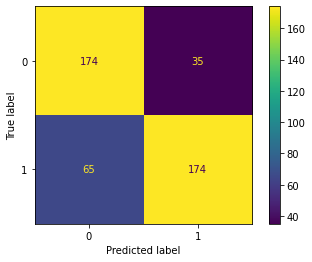

Epoch 1/9


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7511233250421248


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.808953581432573
115/115 - 18s - loss: 1.7828 - auc: 0.7191 - val_loss: 0.5955 - val_auc: 0.7506 - 18s/epoch - 155ms/step
Epoch 2/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7708617507823157


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8394657863145258
115/115 - 16s - loss: 0.4727 - auc: 0.8466 - val_loss: 0.5679 - val_auc: 0.7713 - 16s/epoch - 137ms/step
Epoch 3/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7375230682821151


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8130552220888355
115/115 - 16s - loss: 0.4672 - auc: 0.8553 - val_loss: 0.7691 - val_auc: 0.7362 - 16s/epoch - 135ms/step
Epoch 4/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7692168819706331


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8057923169267707
115/115 - 15s - loss: 0.4385 - auc: 0.8686 - val_loss: 0.6768 - val_auc: 0.7686 - 15s/epoch - 133ms/step
Epoch 5/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.780981705849314


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8380052020808323
115/115 - 15s - loss: 0.4254 - auc: 0.8746 - val_loss: 0.6359 - val_auc: 0.7807 - 15s/epoch - 134ms/step
Epoch 6/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7464194014282275


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8303221288515406
115/115 - 16s - loss: 0.4261 - auc: 0.8747 - val_loss: 0.6710 - val_auc: 0.7468 - 16s/epoch - 136ms/step
Epoch 7/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7958256439059617


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8396658663465386
115/115 - 16s - loss: 0.4174 - auc: 0.8825 - val_loss: 0.6086 - val_auc: 0.7959 - 16s/epoch - 135ms/step
Epoch 8/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7949831501243683


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8611944777911165
115/115 - 16s - loss: 0.4157 - auc: 0.8834 - val_loss: 0.5526 - val_auc: 0.7954 - 16s/epoch - 135ms/step
Epoch 9/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7525174516569044


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.818937575030012
115/115 - 16s - loss: 0.4048 - auc: 0.8842 - val_loss: 0.6339 - val_auc: 0.7521 - 16s/epoch - 135ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.4942910969257355 , AUC = 0.8186874389648438 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.7525174516569044
test 0.818937575030012

-----------------------------------------------------------------


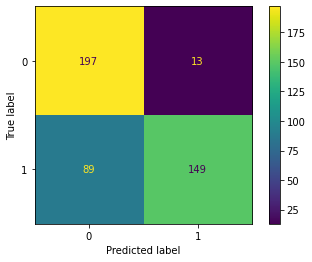

Epoch 1/9


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6824318910256408


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.6991121243025975
115/115 - 18s - loss: 1.6051 - auc: 0.6075 - val_loss: 0.6280 - val_auc: 0.6826 - 18s/epoch - 153ms/step
Epoch 2/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7495793269230769


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8141360209570659
115/115 - 16s - loss: 0.5154 - auc: 0.8194 - val_loss: 0.6271 - val_auc: 0.7492 - 16s/epoch - 135ms/step
Epoch 3/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7930689102564102


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8391525186473894
115/115 - 16s - loss: 0.4740 - auc: 0.8448 - val_loss: 0.5783 - val_auc: 0.7938 - 16s/epoch - 136ms/step
Epoch 4/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7618088942307693


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8257943887855699
115/115 - 16s - loss: 0.4458 - auc: 0.8639 - val_loss: 0.6001 - val_auc: 0.7618 - 16s/epoch - 135ms/step
Epoch 5/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7728465544871794


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8362529245905572
115/115 - 16s - loss: 0.4432 - auc: 0.8699 - val_loss: 0.6658 - val_auc: 0.7725 - 16s/epoch - 135ms/step
Epoch 6/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7721153846153845


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8256744055832184
115/115 - 16s - loss: 0.4366 - auc: 0.8705 - val_loss: 0.6426 - val_auc: 0.7723 - 16s/epoch - 135ms/step
Epoch 7/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7830128205128204


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8358229847821305
115/115 - 15s - loss: 0.4448 - auc: 0.8666 - val_loss: 0.6952 - val_auc: 0.7823 - 15s/epoch - 135ms/step
Epoch 8/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.723036858974359


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8173455716199732
115/115 - 15s - loss: 0.4214 - auc: 0.8788 - val_loss: 0.7528 - val_auc: 0.7229 - 15s/epoch - 134ms/step
Epoch 9/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.776582532051282


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8343331933529305
115/115 - 15s - loss: 0.4128 - auc: 0.8836 - val_loss: 0.7598 - val_auc: 0.7768 - 15s/epoch - 134ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.5425025820732117 , AUC = 0.8353330492973328 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.776582532051282
test 0.8343331933529305

-----------------------------------------------------------------


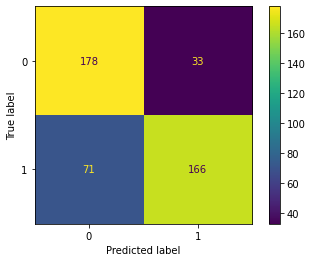

Epoch 1/9


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7179564388236475


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.7967908550379373
115/115 - 18s - loss: 3.0567 - auc: 0.6894 - val_loss: 0.7532 - val_auc: 0.7168 - 18s/epoch - 154ms/step
Epoch 2/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.725293586269196


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.795549638645873
115/115 - 17s - loss: 0.4937 - auc: 0.8355 - val_loss: 0.6392 - val_auc: 0.7241 - 17s/epoch - 146ms/step
Epoch 3/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.755053698685135


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8152289243458589
115/115 - 16s - loss: 0.4618 - auc: 0.8545 - val_loss: 0.6135 - val_auc: 0.7552 - 16s/epoch - 136ms/step
Epoch 4/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7898725283549131


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8458389221437008
115/115 - 16s - loss: 0.4501 - auc: 0.8642 - val_loss: 0.5797 - val_auc: 0.7895 - 16s/epoch - 136ms/step
Epoch 5/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.779664759610559


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8191727893335469
115/115 - 15s - loss: 0.4549 - auc: 0.8656 - val_loss: 0.5887 - val_auc: 0.7788 - 15s/epoch - 134ms/step
Epoch 6/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8067148449262269


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8605133030369763
115/115 - 16s - loss: 0.4472 - auc: 0.8688 - val_loss: 0.5532 - val_auc: 0.8063 - 16s/epoch - 135ms/step
Epoch 7/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7954632138913982


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8343476607074934
115/115 - 15s - loss: 0.4257 - auc: 0.8804 - val_loss: 0.5653 - val_auc: 0.7948 - 15s/epoch - 134ms/step
Epoch 8/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7577135400983639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8304838741967128
115/115 - 15s - loss: 0.4315 - auc: 0.8767 - val_loss: 0.6856 - val_auc: 0.7584 - 15s/epoch - 134ms/step
Epoch 9/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7909766134698384


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8517847490540729
115/115 - 15s - loss: 0.4240 - auc: 0.8765 - val_loss: 0.5318 - val_auc: 0.7900 - 15s/epoch - 135ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.4319460690021515 , AUC = 0.8523252606391907 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.7909766134698384
test 0.8517847490540729

-----------------------------------------------------------------


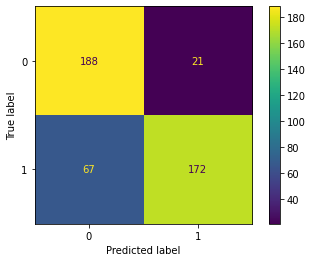

Epoch 1/9


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.6923585113411143


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8002103365384614
115/115 - 18s - loss: 2.1726 - auc: 0.7224 - val_loss: 0.6799 - val_auc: 0.6932 - 18s/epoch - 153ms/step
Epoch 2/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7512262016776441


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8170572916666667
115/115 - 16s - loss: 0.5109 - auc: 0.8290 - val_loss: 0.6474 - val_auc: 0.7515 - 16s/epoch - 136ms/step
Epoch 3/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7492142299453465


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8217848557692308
115/115 - 16s - loss: 0.4744 - auc: 0.8469 - val_loss: 0.5857 - val_auc: 0.7492 - 16s/epoch - 135ms/step
Epoch 4/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7928369802406359


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8403545673076922
115/115 - 16s - loss: 0.4642 - auc: 0.8579 - val_loss: 0.5652 - val_auc: 0.7925 - 16s/epoch - 135ms/step
Epoch 5/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8115753438369603


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8492688301282051
115/115 - 16s - loss: 0.4364 - auc: 0.8701 - val_loss: 0.5315 - val_auc: 0.8114 - 16s/epoch - 135ms/step
Epoch 6/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7750795779864267


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8262019230769231
115/115 - 15s - loss: 0.4472 - auc: 0.8713 - val_loss: 0.7491 - val_auc: 0.7753 - 15s/epoch - 134ms/step
Epoch 7/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.783167504154071


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8169571314102564
115/115 - 15s - loss: 0.4494 - auc: 0.8652 - val_loss: 0.6534 - val_auc: 0.7832 - 15s/epoch - 134ms/step
Epoch 8/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.7896939000220218


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8458633814102564
115/115 - 16s - loss: 0.4277 - auc: 0.8752 - val_loss: 0.6263 - val_auc: 0.7879 - 16s/epoch - 135ms/step
Epoch 9/9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


 | val_auc: 0.8041480651038015


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


 | test_auc: 0.8428986378205128
115/115 - 16s - loss: 0.4188 - auc: 0.8806 - val_loss: 0.5794 - val_auc: 0.8031 - 16s/epoch - 136ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Results: Loss = 0.462230384349823 , AUC = 0.8427383899688721 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


val: 0.8041480651038015
test 0.8428986378205128

-----------------------------------------------------------------


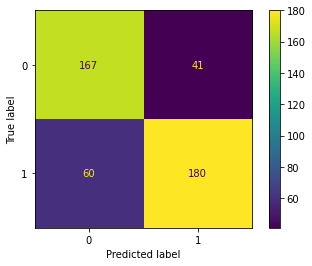

In [63]:
# Create directory to save models
import matplotlib.pyplot as plt
rt_sv_dir = '/content/models'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  MERGM.compile(
      optimizer =  keras.optimizers.Adam(lr=0.01),
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])

  tfeatures = DATA_train [RUN]['MFCCS'][:]
  textra    = DATA_train[RUN]['EXTRA'][:]
  timgs     = DATA_train[RUN]['MEL'][:]
  labels    = DATA_train[RUN]['LABELS'][:]

  test_features= DATA_test[RUN]['MFCCS'][ :]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][ :]
  test_labels  = DATA_test[RUN]['LABELS'][ :]
                                        
  val_features= DATA_val[RUN]['MFCCS'][ :]
  val_extra   = DATA_val[RUN]['EXTRA'][:]
  val_imgs    = DATA_val[RUN]['MEL'][  :]
  val_labels  = DATA_val[RUN]['LABELS'][ :]

  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=32,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(64,64))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=32,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=True)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  MERGM.fit_generator(
                  imgs_em,
                  epochs=9,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  print()
  print('-----------------------------------------------------------------')
  from sklearn.metrics import ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_predictions(y_test[:len(y_preds_test)], y_preds_test>0.5)
  plt.savefig('ConfusionMatrix.png')
  plt.show()

---
# 4-Model Visualization
---

0
Num_samples: 448
acc:  0.7834821428571429
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 448
acc:  0.7879464285714286
2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 448
acc:  0.765625
3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 448
acc:  0.796875
4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 448
acc:  0.7678571428571429


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


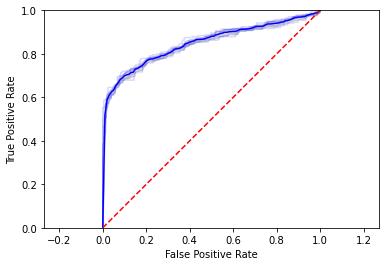

In [65]:


# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: '/content/models/0/005--0.550--0.439.hdf5',
          1: '/content/models/1/008--0.553--0.416.hdf5',
          2: '/content/models/2/003--0.578--0.474.hdf5',
          3: '/content/models/3/009--0.532--0.424.hdf5',
          4: '/content/models/4/005--0.531--0.436.hdf5'
          }

          

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(5):
  print(iii)
  test_features= DATA_test[RUN]['MFCCS'][:]
  test_extra   = DATA_test[RUN]['EXTRA'][:]
  test_imgs    = DATA_test[RUN]['MEL'][:]
  test_labels  = DATA_test[RUN]['LABELS'][:]
  
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=32,target_size=(64,64))

  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  print('Num_samples:', len(y_score))

  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

